In [54]:
!pip install torchinfo

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marjukibnabelayet/coffee-beans-saad")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coffee-beans-saad


In [56]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
from datetime import datetime

In [57]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [58]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [59]:


base_dir = "/kaggle/input/coffee-beans-saad"

def create_dataframe(data_dir):
    file_paths = []
    labels = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # skip files, only consider folders
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            file_paths.append(image_path)
            labels.append(class_name)
    
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)  # shuffle
    return df

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

# Print few rows to confirm
print("Train:", train_df.head())
print("Test:", test_df.head())


Train:                                            file_path   label
0  /kaggle/input/coffee-beans-saad/train/Light/li...   Light
1  /kaggle/input/coffee-beans-saad/train/Light/li...   Light
2  /kaggle/input/coffee-beans-saad/train/Medium/m...  Medium
3  /kaggle/input/coffee-beans-saad/train/Dark/dar...    Dark
4  /kaggle/input/coffee-beans-saad/train/Medium/m...  Medium
Test:                                            file_path   label
0  /kaggle/input/coffee-beans-saad/test/Medium/me...  Medium
1  /kaggle/input/coffee-beans-saad/test/Light/lig...   Light
2  /kaggle/input/coffee-beans-saad/test/Medium/me...  Medium
3  /kaggle/input/coffee-beans-saad/test/Light/lig...   Light
4  /kaggle/input/coffee-beans-saad/test/Dark/dark...    Dark


In [60]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Map class names to integer labels
label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

class CoffeeBeanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        label_name = self.dataframe.iloc[idx]['label']
        label = label_to_idx[label_name]
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [61]:
train_dataset = CoffeeBeanDataset(train_df, transform=train_transforms)
test_dataset = CoffeeBeanDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
from collections import Counter

# Label distribution
train_label_counts = Counter(train_df["label"])
test_label_counts = Counter(test_df["label"])

print("Train Class Distribution:")
for k, v in train_label_counts.items():
    print(f"{k}: {v} images")

print("\nTest Class Distribution:")
for k, v in test_label_counts.items():
    print(f"{k}: {v} images")


Train Class Distribution:
Light: 300 images
Medium: 300 images
Dark: 300 images
Green: 300 images

Test Class Distribution:
Medium: 100 images
Light: 100 images
Dark: 100 images
Green: 100 images


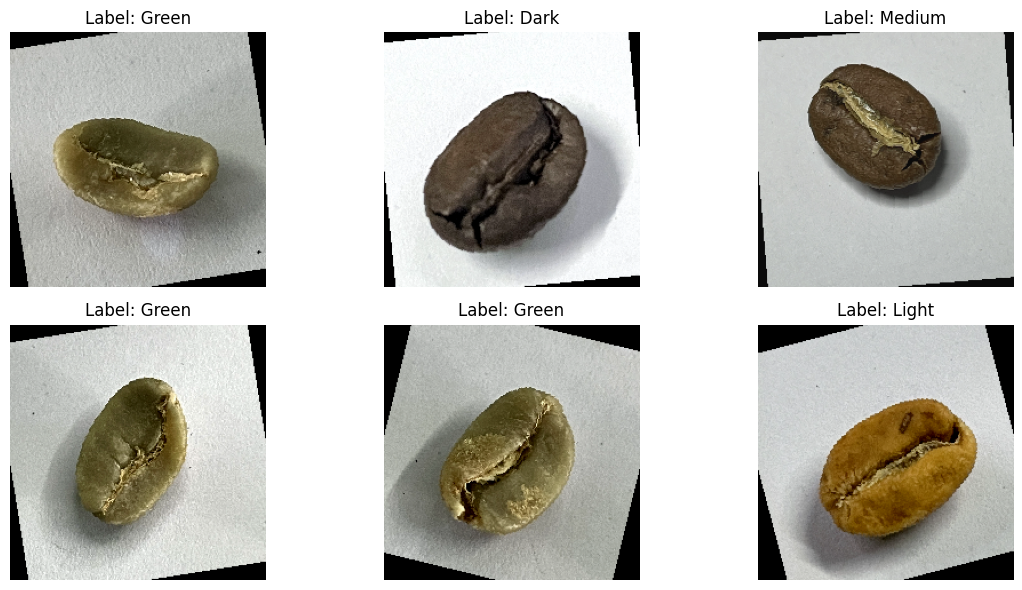

In [63]:
import matplotlib.pyplot as plt

def show_sample_images(loader, class_map, num_images=6):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        label = labels[i].item()
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"Label: {list(class_map.keys())[list(class_map.values()).index(label)]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader, label_to_idx)


In [64]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Split only the training folder data
train_dataframe, valid_dataframe = train_test_split(
    train_df, test_size=0.18, stratify=train_df['label'], random_state=42
)

# Optional cleanup
train_dataframe = train_dataframe.reset_index(drop=True)
valid_dataframe = valid_dataframe.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print dataset sizes
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amount of data: ", len(train_df) + len(test_df))

# Print class distribution
def print_distribution(title, dataframe):
    counts = dataframe['label'].value_counts().sort_index()
    table_data = [[cls, cnt] for cls, cnt in counts.items()]
    print(f"\n{title}")
    print(tabulate(table_data, headers=["Class", "Count"], tablefmt="pretty"))

print_distribution("Train Dataset", train_dataframe)
print_distribution("Validation Dataset", valid_dataframe)
print_distribution("Test Dataset", test_df)


Training Data:  984
Validation Data:  216
Test Data:  400
-------------------------------------------
Total amount of data:  1600

Train Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  246  |
| Green  |  246  |
| Light  |  246  |
| Medium |  246  |
+--------+-------+

Validation Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  54   |
| Green  |  54   |
| Light  |  54   |
| Medium |  54   |
+--------+-------+

Test Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  100  |
| Green  |  100  |
| Light  |  100  |
| Medium |  100  |
+--------+-------+


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [67]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        label_name = self.dataframe.iloc[index]['label']
        label = self.label_map[label_name]
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        return image, label


In [68]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_batch = 32
val_batch = 8

def data_transform():
    # Define train and validation/test transforms separately
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create datasets (no more is_lb flag)
    train_dataset = ImageDataset(train_dataframe, transform=train_transform)
    valid_dataset = ImageDataset(valid_dataframe, transform=val_test_transform)
    test_dataset = ImageDataset(test_df, transform=val_test_transform)

    # Create dataloaders
    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test  = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

# Call to load data
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform()


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # output: 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 32 x 112 x 112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # output: 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 64 x 56 x 56
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # output: 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 128 x 28 x 28
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # output: 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 256 x 14 x 14
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# Usage example:
model = CustomCNN(num_classes=4).to(device)

# Optimizer and loss
import torch.optim as optim

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Print model summary (optional, requires torchinfo)
from torchinfo import summary
summary(model, input_size=(train_batch, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 4]                   --
├─Sequential: 1-1                        [32, 256, 14, 14]         --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

In [70]:
# Imports
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Custom CNN ===
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# === Setup ===
num_classes = 4
learning_rate = 0.0001
train_batch = 32  # update as needed
save_path_checkpoints = "checkpoints"

model = CustomCNN(num_classes).to(device)
summary(model, input_size=(train_batch, 3, 224, 224))

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# === Training Function ===
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset,
                num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):

    os.makedirs(save_path_checkpoints, exist_ok=True)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    print("\n========== Training Started ==========\n")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # ---- Training ----
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f"[Epoch {epoch+1}] Training Loss: {epoch_train_loss:.4f} | Accuracy: {epoch_train_acc:.4f}")

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f"[Epoch {epoch+1}] Validation Loss: {epoch_val_loss:.4f} | Accuracy: {epoch_val_acc:.4f}")

        # ---- Early Stopping and Saving ----
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = os.path.join(save_path_checkpoints, f"best_model_epoch_{best_epoch}.pt")

            torch.save({
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }, filepath)

            print(f"✅ Saved: {filepath} | Best Accuracy: {best_val_acc:.4f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"🛑 Early stop at epoch {epoch+1}")
            break

        print(f"⏱️ Epoch time: {time.time() - epoch_start_time:.2f} seconds\n")

    print("\n✅ Training Complete ✅")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# === Train ===
start_time = time.time()

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
print(f"\n🕒 Total Training Time: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

# === Save Training Logs to Excel ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f"/kaggle/working/training_data_{timestamp}.xlsx"

df = pd.DataFrame({
    'Epoch': list(range(1, len(train_loss_history)+1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
})

df.to_excel(excel_filename, index=False)
print(f"📊 Saved training history: {excel_filename}")



========== Training Started ==========



Epoch 1/20: 100%|██████████| 31/31 [00:02<00:00, 10.60it/s, acc=0.463, loss=2.18]

[Epoch 1] Training Loss: 2.1782 | Accuracy: 0.4634


[Epoch 1] Validation Loss: 1.6124 | Accuracy: 0.2500
✅ Saved: checkpoints/best_model_epoch_1.pt | Best Accuracy: 0.2500
⏱️ Epoch time: 4.40 seconds



Epoch 2/20: 100%|██████████| 31/31 [00:02<00:00, 10.51it/s, acc=0.762, loss=0.592]

[Epoch 2] Training Loss: 0.5921 | Accuracy: 0.7622


[Epoch 2] Validation Loss: 0.5410 | Accuracy: 0.7731
✅ Saved: checkpoints/best_model_epoch_2.pt | Best Accuracy: 0.7731
⏱️ Epoch time: 4.47 seconds



Epoch 3/20: 100%|██████████| 31/31 [00:03<00:00,  9.77it/s, acc=0.829, loss=0.44] 

[Epoch 3] Training Loss: 0.4398 | Accuracy: 0.8293


[Epoch 3] Validation Loss: 0.2904 | Accuracy: 0.9167
✅ Saved: checkpoints/best_model_epoch_3.pt | Best Accuracy: 0.9167
⏱️ Epoch time: 4.70 seconds



Epoch 4/20: 100%|██████████| 31/31 [00:02<00:00, 10.49it/s, acc=0.865, loss=0.356]

[Epoch 4] Training Loss: 0.3564 | Accuracy: 0.8648


[Epoch 4] Validation Loss: 0.1947 | Accuracy: 0.9444
✅ Saved: checkpoints/best_model_epoch_4.pt | Best Accuracy: 0.9444
⏱️ Epoch time: 4.49 seconds



Epoch 5/20: 100%|██████████| 31/31 [00:02<00:00, 10.51it/s, acc=0.887, loss=0.281]

[Epoch 5] Training Loss: 0.2813 | Accuracy: 0.8872


[Epoch 5] Validation Loss: 0.2399 | Accuracy: 0.9120
⏱️ Epoch time: 3.52 seconds



Epoch 6/20: 100%|██████████| 31/31 [00:02<00:00, 10.44it/s, acc=0.899, loss=0.265]

[Epoch 6] Training Loss: 0.2654 | Accuracy: 0.8994


[Epoch 6] Validation Loss: 0.1506 | Accuracy: 0.9769
✅ Saved: checkpoints/best_model_epoch_6.pt | Best Accuracy: 0.9769
⏱️ Epoch time: 4.50 seconds



Epoch 7/20: 100%|██████████| 31/31 [00:02<00:00, 10.60it/s, acc=0.917, loss=0.231]

[Epoch 7] Training Loss: 0.2306 | Accuracy: 0.9167


[Epoch 7] Validation Loss: 0.1982 | Accuracy: 0.9444
⏱️ Epoch time: 3.51 seconds



Epoch 8/20: 100%|██████████| 31/31 [00:03<00:00, 10.09it/s, acc=0.946, loss=0.165]

[Epoch 8] Training Loss: 0.1650 | Accuracy: 0.9461


[Epoch 8] Validation Loss: 0.1714 | Accuracy: 0.9491
⏱️ Epoch time: 3.63 seconds



Epoch 9/20: 100%|██████████| 31/31 [00:03<00:00,  9.96it/s, acc=0.924, loss=0.207]

[Epoch 9] Training Loss: 0.2069 | Accuracy: 0.9238


[Epoch 9] Validation Loss: 0.1776 | Accuracy: 0.9444
⏱️ Epoch time: 3.69 seconds



Epoch 10/20: 100%|██████████| 31/31 [00:02<00:00, 10.35it/s, acc=0.938, loss=0.162]

[Epoch 10] Training Loss: 0.1623 | Accuracy: 0.9380


[Epoch 10] Validation Loss: 0.1562 | Accuracy: 0.9537
⏱️ Epoch time: 3.55 seconds



Epoch 11/20: 100%|██████████| 31/31 [00:02<00:00, 10.33it/s, acc=0.949, loss=0.15] 

[Epoch 11] Training Loss: 0.1495 | Accuracy: 0.9492


[Epoch 11] Validation Loss: 0.1155 | Accuracy: 0.9676
🛑 Early stop at epoch 11

✅ Training Complete ✅

🕒 Total Training Time: 44.03 seconds (0.73 minutes)
📊 Saved training history: /kaggle/working/training_data_20250803_204348.xlsx


In [71]:
# Grad-CAM Setup and Visualization
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax().item()

        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]  # [C, H, W]

        for i in range(activations.shape[0]):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.sum(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

def show_gradcam_on_image(image_tensor, heatmap, alpha=0.4):
    # Convert tensor to numpy image [H, W, C] in range 0-1
    image = image_tensor.squeeze(0).cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = np.clip(image, 0, 1)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored[..., ::-1]  # Convert BGR to RGB

    # Superimpose heatmap onto image
    superimposed_img = heatmap_colored.astype(float) * alpha + (image * 255).astype(float)
    superimposed_img = superimposed_img / superimposed_img.max()
    superimposed_img = np.uint8(255 * superimposed_img)

    # Plot original and Grad-CAM
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Heatmap max: 1.0
Heatmap min: 0.0
Heatmap mean: 0.22486864


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


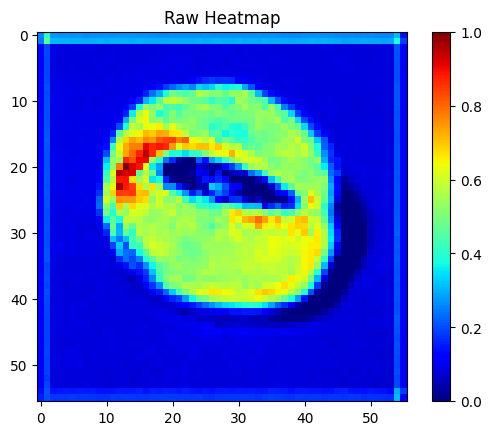

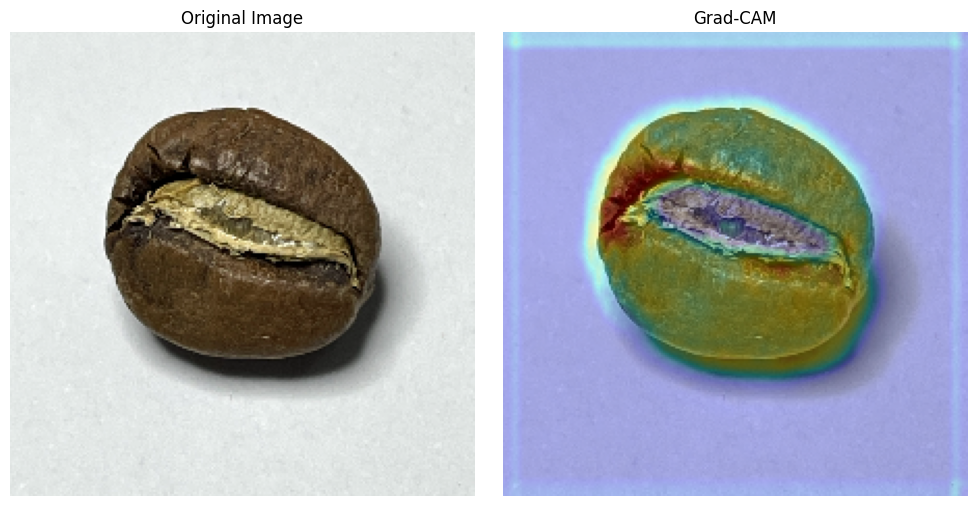

In [72]:
# === Run Grad-CAM on one test image ===

import glob

# Load the best checkpoint if available
best_model_path = sorted(glob.glob(os.path.join(save_path_checkpoints, "best_model_epoch_*.pt")))[-1]
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Get a sample from the test set
sample_img, sample_label = next(iter(dataloader_test_dataset))
sample_img = sample_img[0].unsqueeze(0).to(device)   # shape: [1, 3, 224, 224]
sample_label = sample_label[0].item()

# ✅ Select the last conv layer of your model
last_conv_layer = model.features[10]  # Correct: Conv2d(64, 128, ...)

# Initialize GradCAM
gradcam = GradCAM(model, target_layer=last_conv_layer)

# Generate heatmap (can use predicted class by omitting target_class)
heatmap = gradcam.generate(sample_img, target_class=sample_label)
print("Heatmap max:", np.max(heatmap))
print("Heatmap min:", np.min(heatmap))
print("Heatmap mean:", np.mean(heatmap))

plt.imshow(heatmap, cmap="jet")
plt.title("Raw Heatmap")
plt.colorbar()
plt.show()


# Show heatmap
show_gradcam_on_image(sample_img, heatmap)


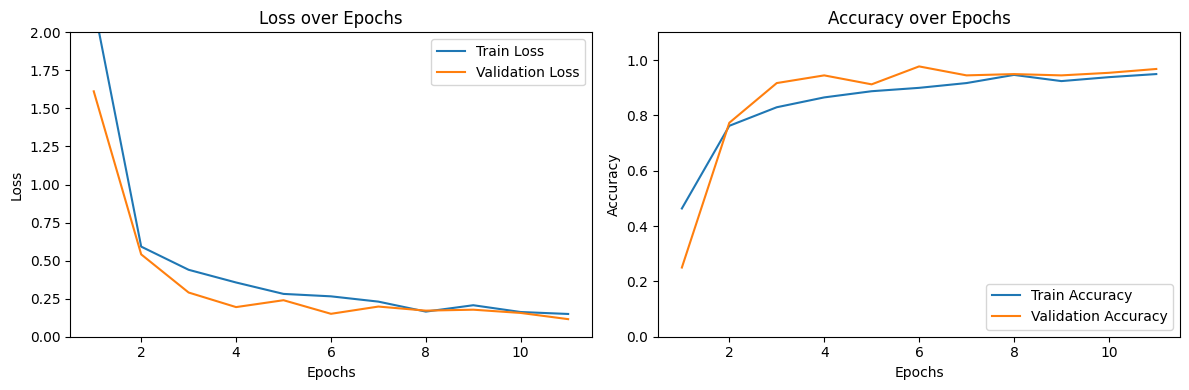

In [73]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

# Find the most recent training history Excel file
excel_files = sorted(glob.glob("/kaggle/working/training_data_*.xlsx"))
if not excel_files:
    raise FileNotFoundError("No training_data_*.xlsx file found in /kaggle/working/")
latest_excel_file = excel_files[-1]

# Load the data
history = pd.read_excel(latest_excel_file)

# Plotting
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, 2)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Epoch'], history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()


In [74]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader_test, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(dataloader_test.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return np.array(all_labels), np.array(all_preds)

# Use your test dataloader and device
y_true, y_pred = evaluate_model(model, dataloader_test_dataset, device)


Test Loss: 0.1566
Test Accuracy: 0.9575


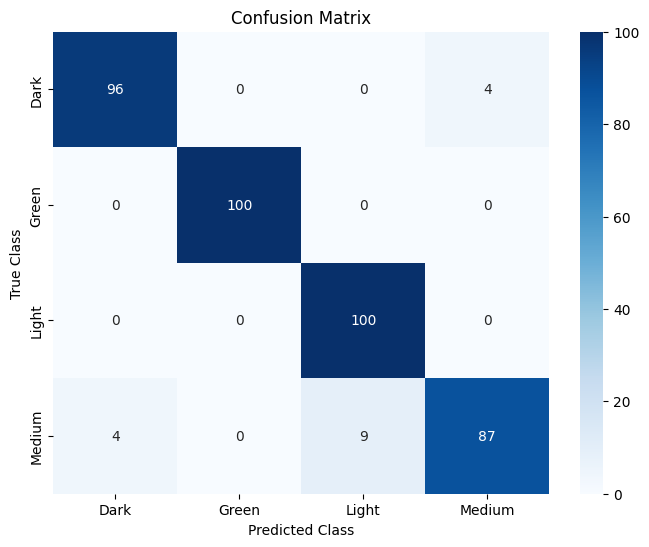

Classification Report:

              precision    recall  f1-score   support

        Dark       0.96      0.96      0.96       100
       Green       1.00      1.00      1.00       100
       Light       0.92      1.00      0.96       100
      Medium       0.96      0.87      0.91       100

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [75]:
# Classes must match your label_map order
class_names = ['Dark', 'Green', 'Light', 'Medium']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [76]:
print(model.features)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.2, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.3, inplace=False)
)
